In [34]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import sys
sys.path.append('../../')

from src.preprocessing import compute_phases, split_trajectories, filter_trajectories
from src.viz import plot_trajectories
from src.io import load_dataframe, save_dataframe

In the CLI script make_phase.py, we select trajectory of fixed length : 1000 timesteps.

In [35]:
df_raw = pd.read_parquet("../../data/toy_model/raw/helix_and_straight_lines.parquet")
df_raw.head()

,x,y,z,label,frame
0,3.000000,0.000000,0.000000,0,0
1,2.828128,1.000846,0.108269,0,1
2,2.332205,1.887014,0.216537,0,2
3,1.569054,2.556965,0.324806,0,3
4,0.626119,2.933935,0.433075,0,4


In [36]:
# Path to raw copepod tracking data
df = pd.read_parquet('../../data/toy_model/interim/phases.parquet')
df.head()


,x,y,z,label,frame,speed,curvature_angle,torsion_angle,abs_torsion_angle
0,2.829878,1.002262,0.108269,1,1,1.021470,0.346036,0.035931,0.035931
1,2.329580,1.884890,0.216537,1,2,1.020218,0.332763,0.036084,0.036084
2,1.567289,2.554087,0.324806,1,3,1.020115,0.338196,0.036448,0.036448
3,0.625415,2.930633,0.433075,1,4,1.020115,0.338196,0.036448,0.036448
4,-0.388120,2.971383,0.541343,1,5,1.020115,0.338196,0.036448,0.036448


In [37]:
print(f"{len(df)} rows from {df['label'].nunique()} trajectories")

997000 rows from 1000 trajectories


<Axes3D: title={'center': 'Trajectories'}, xlabel='x', ylabel='y', zlabel='z'>

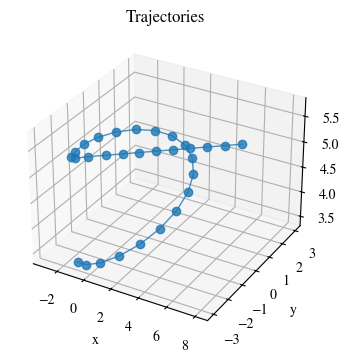

In [38]:
plot_trajectories(df, xcol='x',ycol='y',zcol='z',t_min=30,t_max=60, sample=1,groupby='label',fig_kwargs={"figsize":(4,5)},ax_kwargs={"marker":"o"})

<Axes: title={'center': 'Trajectories'}, xlabel='speed', ylabel='torsion_angle'>

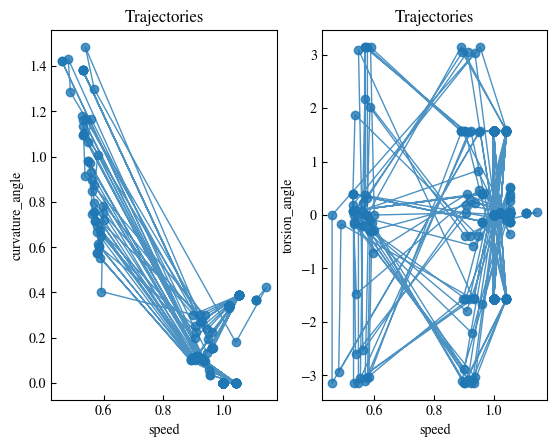

In [39]:
fig,ax = plt.subplots(ncols=2)
plot_trajectories(df,ax=ax[0] ,ycol='curvature_angle',xcol='speed', sample=1,groupby='label',fig_kwargs={"figsize":(4,5)},ax_kwargs={"marker":"o"},t_min=0,t_max=-1)
plot_trajectories(df,ax=ax[1], ycol='torsion_angle',xcol='speed', sample=1,groupby='label',fig_kwargs={"figsize":(4,5)},ax_kwargs={"marker":"o"},t_min=0,t_max=-1)


Text(0, 0.5, 'absolute torsion angle')

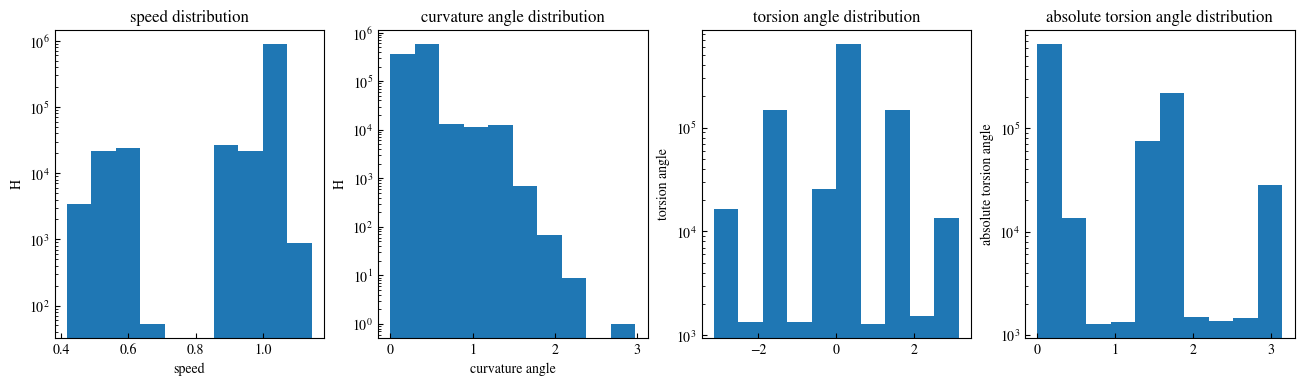

In [40]:
fig,ax = plt.subplots(ncols=4, figsize= (16,4))
ax[0].hist(df['speed'])
ax[1].hist(df['curvature_angle'])
ax[2].hist(df['torsion_angle'])
ax[3].hist(df['abs_torsion_angle'])

for i in range(4):
    ax[i].set_yscale('log')
    ax[i].set_ylabel('H')

ax[0].set_title('speed distribution')
ax[0].set_xlabel('speed')

ax[1].set_title('curvature angle distribution')
ax[1].set_xlabel('curvature angle')

ax[2].set_title('torsion angle distribution')
ax[2].set_ylabel('torsion angle')

ax[3].set_title('absolute torsion angle distribution')
ax[3].set_ylabel('absolute torsion angle')


Now GPT suggested to distinguish the trajectories as a function of the speed or curvature. We don't do that now.

df_phase = compute_phases(
    df_filtered,
    column_names=("x", "y","z"),  # or ("x", "y", "z") if 3D
    dt=1.0
)

# Assign phase labels
speed_thresh = 0.4
turn_thresh = 1.0
df_phase["phase"] = (
    (df_phase["speed"] > speed_thresh).astype(int) +
    (df_phase["curvature_angle"] > turn_thresh).astype(int)
)
df_phase.head()


df_phase["phase"].value_counts().sort_index().plot(kind="bar", color="tab:blue")
plt.xticks([0, 1, 2], ["Rest", "Swim", "Turn"])
plt.ylabel("Frame count")
plt.title("Phase distribution")


Look a at the translated embedding of positions


In [41]:
# Paths to data from embed_and_cluster.py
with open("../../data/toy_model/processed/embedding.pkl", "rb") as f:
        emb = pickle.load(f)

print(f"Labels shape: {emb.labels}")
print(f"Embedding shape: {emb.embedding_matrix.shape}")


Labels shape: [23  4  4 ...  0  0  0]
Embedding shape: (1000, 968, 180)


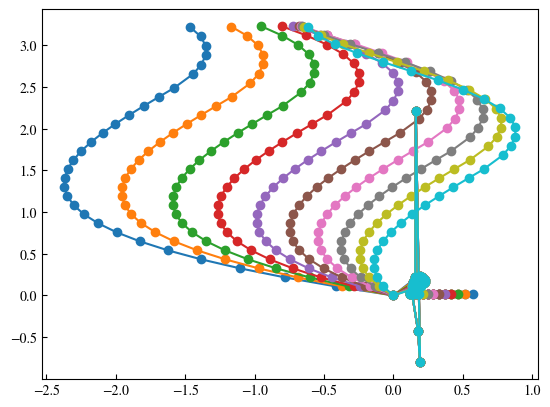

In [42]:
ax = plt.subplot()#projection="3d")
for i in range(10):#emb.embedding_matrix.shape[1]):
    x,y,z = emb.embedding_matrix[0][i][0::3],emb.embedding_matrix[0][i][1::3],emb.embedding_matrix[0][i][2::3]    
    ax.plot(x,z,marker='o')


In [26]:
# Extract both sets of trajectories with same T_min
columns= ['speed','curvature_angle','torsion_angle']
columns_translated = ['x','y','z']
ID_NAME = 'label'

trajs_abs, trajs_trans, T_min = [], [], np.inf
for _, traj_df in df.groupby(ID_NAME, sort=False):
    traj_abs = traj_df.sort_index()[columns].values.astype(float)
    traj_trans = traj_df.sort_index()[columns_translated].values.astype(float)
    T_min = min(T_min, traj_abs.shape[0], traj_trans.shape[0])
    trajs_abs.append(traj_abs)
    trajs_trans.append(traj_trans)

Y_abs = np.stack([traj[:T_min] for traj in trajs_abs])
Y_trans = np.stack([traj[:T_min] for traj in trajs_trans])

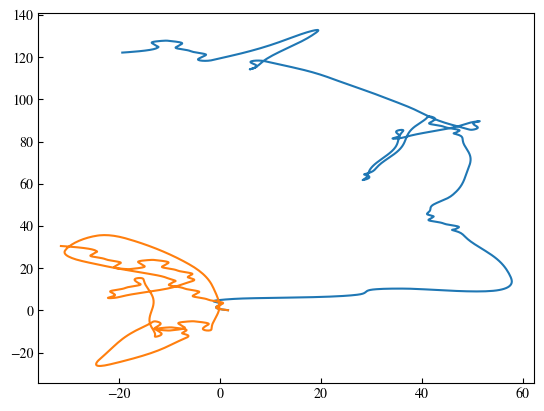

In [29]:
plt.plot(Y_trans[0,:,0],Y_trans[0,:,2])
plt.plot(Y_trans[1,:,0],Y_trans[1,:,2])